## Analysis of mutants to A12_2718 strain rabies G on pseudovirus

This process neutralization assays for mutants to the rabies G on pseudovirus for strain A12_2718 (noted as 'AGN' below for convenience). This notebook has dependencies for files in RawData directory.


File dependencies:
- 241016_AGN-muts_TitreData_Reanalysis.xlsx has all neutralization assay data, plate maps, antibody maps as separate sheets within single xlsx file

In [1]:
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sb
import numpy as np
import matplotlib.cm as cm
import scipy.stats
from matplotlib.colors import ListedColormap

In [2]:
#read in excel documents with data


Plate1_data = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','PV-17C7');
Plate1_data['plate_num']=1;

Plate2_data = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','AGN-17C7');
Plate2_data['plate_num']=2;

Plate3_data = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','PV-RVC58');
Plate3_data['plate_num']=3;

Plate4_data = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','AGN-RVC58');
Plate4_data['plate_num']=4;


#antibody map

antibody_map_17C7= pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','AntibodyMap_17C7');
antibody_map_RVC58= pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','AntibodyMap_RVC58');

#virus map
plate_map_PV = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','PV-Plate');
plate_map_AGN = pd.read_excel('RawData/241016_AGN-muts_TitreData_Reanalysis.xlsx','AGN-Plate');


In [3]:
#process plate reader data from raw format

def format_plate_data(plate_df,antibodymap_df,platemap_df):
    #take plate_df and convert well into Row and Column
    plate_copy = plate_df.copy();

    plate_copy['row']=plate_copy['Well'].apply(lambda x: x[0]);
    plate_copy['column']=plate_copy['Well'].apply(lambda x: int(x[1:]));

    #okay now merge with plate_map
    plate_copy = pd.merge(plate_copy,platemap_df,how='left',on=['row','column']);

    #now we need to merge in the antibody map and get concentrations.
    plate_copy = pd.merge(plate_copy,antibodymap_df,how='left',on=['column'])

    #get the median 'RLU' of values where virus is NoVirus
    median_bg = plate_copy.loc[plate_copy['virus'] == 'NoVirus', 'RLU'].median();
    #bg subtract
    plate_copy['RLU'] = plate_copy['RLU']-median_bg;

    #okay let's convert the Row values to an ordinal value for dilution factor.
    plate_copy['Dilution_factor']=plate_copy['row'].apply(lambda x: ord(x)-65);
    plate_copy['antibody_conc']=plate_copy['high_concentration']/5**plate_copy['Dilution_factor']

    #okay now we need to calculate the RLU fraction.
    #let me make a minor formatting adjustment where the plate antibody column if 'nan' is actually 'NA'
    plate_copy['antibody'] = plate_copy['antibody'].fillna('None')
    

    return plate_copy;

Plate1_data_processed = format_plate_data(Plate1_data,antibody_map_17C7,plate_map_PV);
Plate2_data_processed = format_plate_data(Plate2_data,antibody_map_17C7,plate_map_AGN);
Plate3_data_processed = format_plate_data(Plate3_data,antibody_map_RVC58,plate_map_PV);
Plate4_data_processed = format_plate_data(Plate4_data,antibody_map_RVC58,plate_map_AGN);



In [4]:
def normalize_rlu(group):
    # Get the median of 'RLU' values where 'Antibody' is 'NA'
    median_rlu = group.loc[group['antibody'] == 'None', 'RLU'].median()

    # Normalize 'RLU' values by dividing by the median
    group['Normalized_RLU'] = group['RLU'] / median_rlu
    return group

# Group by 'Virus' and apply the normalization function
normalized_plate1 = Plate1_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate1 = normalized_plate1[normalized_plate1['antibody']!='None'];
normalized_plate1 = normalized_plate1[normalized_plate1['virus']!='NoVirus'];



normalized_plate2 = Plate2_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate2 = normalized_plate2[normalized_plate2['antibody']!='None'];
normalized_plate2 = normalized_plate2[normalized_plate2['virus']!='NoVirus'];



normalized_plate3 = Plate3_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate3 = normalized_plate3[normalized_plate3['antibody']!='None'];
normalized_plate3 = normalized_plate3[normalized_plate3['virus']!='NoVirus'];


normalized_plate4 = Plate4_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
normalized_plate4 = normalized_plate4[normalized_plate4['antibody']!='None'];
normalized_plate4 = normalized_plate4[normalized_plate4['virus']!='NoVirus'];






/tmp/ipykernel_11486/1784591479.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_plate1 = Plate1_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
/tmp/ipykernel_11486/1784591479.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_plate2 = Plate2_data_processed.groupby('virus').apply(normalize_rlu).reset_index(drop=True)
/tmp/ipykernel_11486/1784591479.py

In [5]:
#okay maybe we should format some things to make neut-curve compatible.

neutCurve_subset_1=normalized_plate1[['virus','antibody','Normalized_RLU','antibody_conc','column']];
neutCurve_subset_1 = neutCurve_subset_1.rename(columns={'antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'column':'replicate','antibody_conc':'concentration'})
                                                        

neutCurve_subset_2=normalized_plate2[['virus','antibody','Normalized_RLU','antibody_conc','column']];
neutCurve_subset_2 = neutCurve_subset_2.rename(columns={'antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'column':'replicate','antibody_conc':'concentration'})

neutCurve_subset_3=normalized_plate3[['virus','antibody','Normalized_RLU','antibody_conc','column']];
neutCurve_subset_3 = neutCurve_subset_3.rename(columns={'antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'column':'replicate','antibody_conc':'concentration'})

neutCurve_subset_4=normalized_plate4[['virus','antibody','Normalized_RLU','antibody_conc','column']];
neutCurve_subset_4 = neutCurve_subset_4.rename(columns={'antibody':'serum','Normalized_RLU':'fraction infectivity',
                                                        'column':'replicate','antibody_conc':'concentration'})


## Figure S6B

In [6]:
import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

pd.set_option('display.float_format', '{:.3g}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

import os
import yaml

import neutcurve.parse_excel

In [7]:
fits = neutcurve.CurveFits(neutCurve_subset_1)

In [8]:
fits.fitParams(ics=(50,90,99))

/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:803: OptimizeWarning: Covariance of the parameters could not be estimated
  (popt, pcov) = scipy.optimize.curve_fit(


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,PV,average,2,0.122,interpolated,0.122,0.525,interpolated,0.525,...,interpolated,2.58,0.122,0.122,interpolated,1.5,1,0,0.896,0.113
1,17C7,PV-I338T,average,2,500,lower,>500,500,lower,>500,...,lower,>500,3.34e+10,500,lower,112,1,0,-1.18,0.334
2,17C7,PV-R346S,average,2,0.597,interpolated,0.597,30.6,interpolated,30.6,...,lower,>500,0.597,0.597,interpolated,0.558,1,0,0.937,0.0923


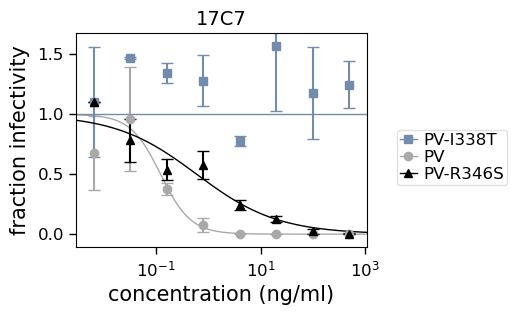

In [9]:
fig, axes = fits.plotSera(xlabel='concentration (ng/ml)',
                          virus_to_color_marker={'PV-I338T':('#748CAB','s'),
                                                 'PV':('darkgrey','o'),
                                                'PV-R346S':('black','^')})

#suppress
#fig.savefig('241202_17C7_PV_curves.svg')

In [10]:
#neutCurve_subset_2_noPV= neutCurve_subset_2[neutCurve_subset_2['virus']!='PV']



fits_2 = neutcurve.CurveFits(neutCurve_subset_2,fixtop=True)
fits_2.fitParams(ics=(50,90,99))


/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)
/home/aaditham/miniconda3/envs/dms-vep-pipeline-3/lib/python3.11/site-packages/neutcurve/hillcurve.py:1177: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,17C7,AGN,average,2,500,lower,>500,500,lower,>500,...,lower,>500,639,500,lower,10.2,1,0,-0.0835,0.209
1,17C7,AGN-S346R,average,2,500,lower,>500,500,lower,>500,...,lower,>500,701,500,lower,7.84,1,0,-0.228,0.147
2,17C7,AGN-T338I,average,2,4.06,interpolated,4.06,16.7,interpolated,16.7,...,interpolated,78.2,4.06,4.06,interpolated,1.55,1,0,0.71,0.336
3,17C7,PV,average,2,0.731,interpolated,0.731,0.874,interpolated,0.874,...,interpolated,1.06,0.731,0.731,interpolated,12.4,1,0,0.381,0.949


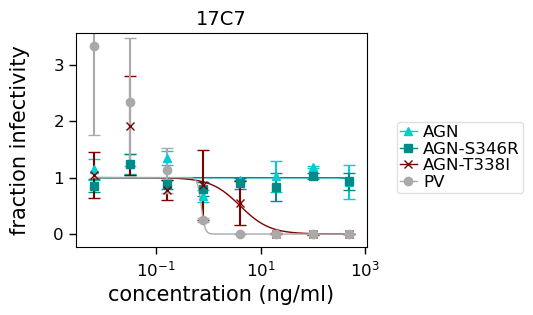

In [11]:
fig, axes = fits_2.plotSera(xlabel='concentration (ng/ml)',draw_in_bounds=True,
                            virus_to_color_marker={'AGN':('darkturquoise','^'),
                                                   'AGN-S346R':('darkcyan','s'),
                                                   'AGN-T338I':('maroon','x'),
                                                   'PV':('darkgrey','o')})

#suppress
#fig.savefig('241202_17C7_PV_Validations.svg');


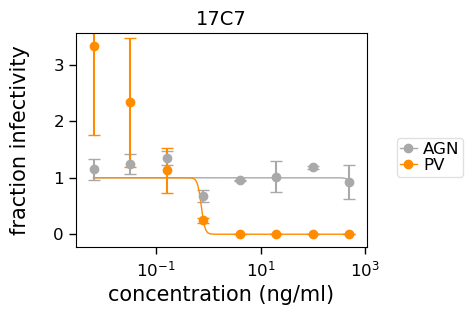

In [15]:
fig, axes = fits_2.plotSera(xlabel='concentration (ng/ml)',draw_in_bounds=True,
                            virus_to_color_marker={'AGN':('darkgrey','o'),
                                                   'PV':('darkorange','o')},
                            viruses = ['AGN','PV'])

fig.savefig('241202_17C7_PV_Validations_subset-unmutated.svg');


In [16]:
fits_3 = neutcurve.CurveFits(neutCurve_subset_3,fixtop=True)
fits_3.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,RVC58,PV,average,2,0.0542,interpolated,0.0542,0.142,interpolated,0.142,...,interpolated,0.408,0.0542,0.0542,interpolated,2.28,1,0,0.991,0.0324
1,RVC58,PV-I338T,average,2,0.0451,interpolated,0.0451,1.24,interpolated,1.24,...,interpolated,45.9,0.0451,0.0451,interpolated,0.664,1,0,0.965,0.046
2,RVC58,PV-R346S,average,2,0.0294,interpolated,0.0294,0.11,interpolated,0.11,...,interpolated,0.461,0.0294,0.0294,interpolated,1.67,1,0,0.982,0.035


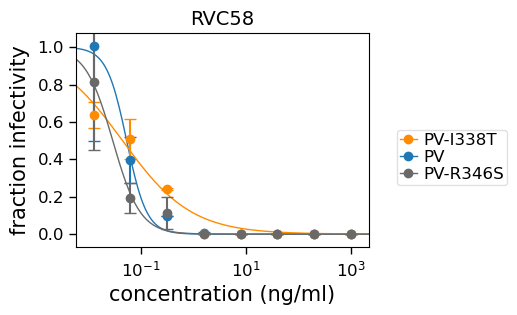

In [17]:
fig, axes = fits_3.plotSera(xlabel='concentration (ng/ml)',
                            virus_to_color_marker={'PV-I338T':('darkorange','o'),
                                                   'PV':('#1f77b4','o'),
                                                   'PV-R346S':('dimgrey','o')})
#fig.savefig('241202_RVC58_PV_Validations.svg');

In [18]:
fits_4 = neutcurve.CurveFits(neutCurve_subset_4,fixtop=True)
fits_4.fitParams(ics=(50,90,99))

,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,ic90,ic90_bound,ic90_str,...,ic99_bound,ic99_str,midpoint,midpoint_bound,midpoint_bound_type,slope,top,bottom,r2,rmsd
0,RVC58,AGN,average,2,0.23,interpolated,0.23,1.15,interpolated,1.15,...,interpolated,6.68,0.23,0.23,interpolated,1.36,1,0,0.986,0.0453
1,RVC58,AGN-S346R,average,2,0.188,interpolated,0.188,2.29,interpolated,2.29,...,interpolated,35.2,0.188,0.188,interpolated,0.878,1,0,0.969,0.0577
2,RVC58,AGN-T338I,average,2,0.0363,interpolated,0.0363,0.0817,interpolated,0.0817,...,interpolated,0.198,0.0363,0.0363,interpolated,2.71,1,0,0.968,0.0542
3,RVC58,PV,average,2,0.097,interpolated,0.097,0.406,interpolated,0.406,...,interpolated,1.93,0.097,0.097,interpolated,1.54,1,0,0.957,0.0811


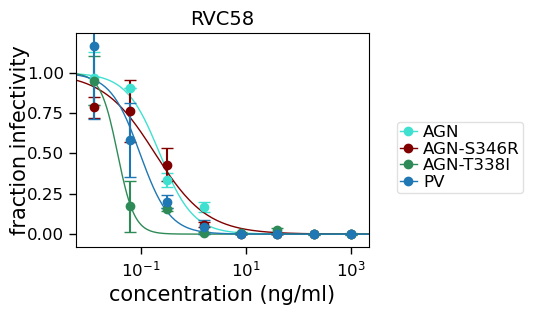

In [19]:
fig, axes = fits_4.plotSera(xlabel='concentration (ng/ml)',
                            virus_to_color_marker={'AGN':('turquoise','o'),
                                                   'AGN-S346R':('maroon','o'),
                                                   'AGN-T338I':('seagreen','o'),
                                                   'PV':('#1f77b4','o')})

#fig.savefig('241202_RVC58_AGN_Validations.svg');


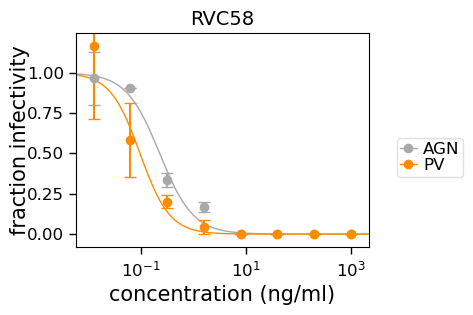

In [20]:
fig, axes = fits_4.plotSera(xlabel='concentration (ng/ml)',
                            virus_to_color_marker={'AGN':('darkgrey','o'),
                                                   'PV':('darkorange','o')},
                            viruses = ['AGN','PV'])

#fig.savefig('241202_RVC58_AGN_Validations_subset-unmutated.svg');
